In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import os
import pickle
from PIL import Image
import random
import warnings
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Accuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\Juan\AppData\Local\Temp\ipykernel_23888\987981624.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Reading dataset as dataframe

df_img = pd.read_csv('./../data/cleaned/ferplus.csv')
df_img.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_2296,Pixel_2297,Pixel_2298,Pixel_2299,Pixel_2300,Pixel_2301,Pixel_2302,Pixel_2303,Pixel_2304,Label
0,30,24,21,23,25,25,49,67,84,103,...,106,111,148,137,176,174,172,173,173,anger
1,123,125,124,142,209,226,234,236,231,232,...,103,116,111,105,105,103,97,91,89,anger
2,236,230,225,226,228,209,199,193,196,211,...,192,190,186,171,144,144,152,155,173,anger
3,255,82,0,3,0,0,0,0,0,0,...,101,217,255,198,143,236,254,254,254,anger
4,206,208,209,212,214,216,216,219,221,222,...,38,42,50,47,26,31,29,40,5,anger


In [4]:
df_img['Label'].value_counts().sort_values(ascending=False)

Label
neutral      12905
happiness     9355
surprise      4462
sadness       4370
anger         3110
fear           819
disgust        248
contempt       216
Name: count, dtype: int64

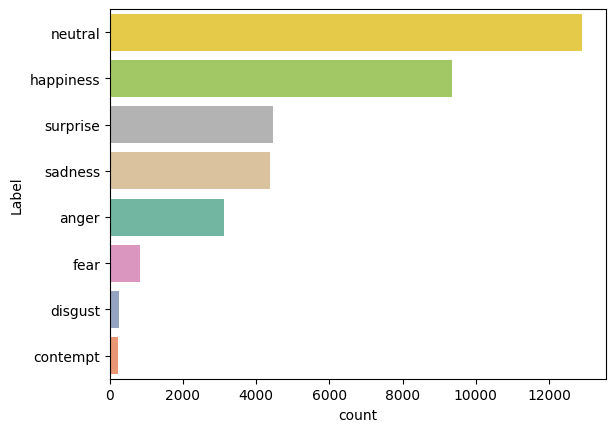

In [5]:
# Checking how many images we have for each label

counts = df_img['Label'].value_counts().sort_values(ascending=False)

sns.countplot(y=df_img['Label'], hue=df_img['Label'], order=counts.index, palette='Set2')
plt.show()

In [6]:
pixel_cols = [col for col in df_img.columns if 'Pixel' in col]

for col in pixel_cols:
    df_img[col].astype(float)

In [7]:
def normalize(value):
    return value/255

In [8]:
df_img.iloc[:, :-1] = df_img.iloc[:, :-1].apply(normalize)

df_img.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_2296,Pixel_2297,Pixel_2298,Pixel_2299,Pixel_2300,Pixel_2301,Pixel_2302,Pixel_2303,Pixel_2304,Label
0,0.117647,0.094118,0.082353,0.090196,0.098039,0.098039,0.192157,0.262745,0.329412,0.403922,...,0.415686,0.435294,0.580392,0.537255,0.690196,0.682353,0.674510,0.678431,0.678431,anger
1,0.482353,0.490196,0.486275,0.556863,0.819608,0.886275,0.917647,0.925490,0.905882,0.909804,...,0.403922,0.454902,0.435294,0.411765,0.411765,0.403922,0.380392,0.356863,0.349020,anger
2,0.925490,0.901961,0.882353,0.886275,0.894118,0.819608,0.780392,0.756863,0.768627,0.827451,...,0.752941,0.745098,0.729412,0.670588,0.564706,0.564706,0.596078,0.607843,0.678431,anger
3,1.000000,0.321569,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.396078,0.850980,1.000000,0.776471,0.560784,0.925490,0.996078,0.996078,0.996078,anger
4,0.807843,0.815686,0.819608,0.831373,0.839216,0.847059,0.847059,0.858824,0.866667,0.870588,...,0.149020,0.164706,0.196078,0.184314,0.101961,0.121569,0.113725,0.156863,0.019608,anger


In [9]:
labels = df_img['Label'].unique().tolist()

mapping_dict = dict(zip(labels, range(8)))

df_img['Label'] = df_img['Label'].replace(mapping_dict)

df_img['Label'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [10]:
# Splitting dataset into X and y

X = df_img.drop(columns='Label')
y = df_img['Label']

In [11]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28388, 2304), (7097, 2304), (28388,), (7097,))

In [12]:
# Converting train and test dfs to numpy arrays

X_train_np = np.array(X_train).reshape((-1, 48, 48, 1))
y_train_np = np.array(y_train)
X_test_np = np.array(X_test).reshape((-1, 48, 48, 1))
y_test_np = np.array(y_test)

In [20]:
class_labels = np.unique(y_train_np)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train_np)
class_weight_dict = dict(zip(class_labels, class_weights))

In [21]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [27]:
model = models.Sequential()

# Conv layers
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flattening + dense layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(8, activation='softmax'))

In [28]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [29]:
history = model.fit(
    datagen.flow(X_train_np, y_train_np, batch_size=32),
    steps_per_epoch=len(X_train_np) // 32,
    epochs=10,
    validation_data=(X_test_np, y_test_np),
    class_weight=class_weight_dict
)

Epoch 1/10
887/887 [==============================] - 11s 11ms/step - loss: 2.6111 - accuracy: 0.1390 - val_loss: 145.8107 - val_accuracy: 0.0878
Epoch 2/10
887/887 [==============================] - 9s 11ms/step - loss: 2.2141 - accuracy: 0.1354 - val_loss: 752.3403 - val_accuracy: 0.0876
Epoch 3/10
887/887 [==============================] - 9s 10ms/step - loss: 2.0449 - accuracy: 0.1644 - val_loss: 494.3441 - val_accuracy: 0.1336
Epoch 4/10
887/887 [==============================] - 9s 10ms/step - loss: 1.9057 - accuracy: 0.2127 - val_loss: 151.0248 - val_accuracy: 0.2308
Epoch 5/10
887/887 [==============================] - 10s 11ms/step - loss: 1.7733 - accuracy: 0.2800 - val_loss: 153.3444 - val_accuracy: 0.3623
Epoch 6/10
887/887 [==============================] - 9s 10ms/step - loss: 1.6992 - accuracy: 0.3263 - val_loss: 465.9091 - val_accuracy: 0.0895
Epoch 7/10
887/887 [==============================] - 9s 10ms/step - loss: 1.6315 - accuracy: 0.3411 - val_loss: 374.8980 - val_